# Instalacion de dependencias.

In [2]:
#Supabase es el proveedor de base de datos utilizado para almacenar las landmarks.
!pip install supabase

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 2.6 MB/s eta 0:00:00


In [30]:
!pip install python-dotenv

# Importaciones

In [3]:
from supabase import create_client
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Funciones utiles

In [4]:

def get_cols_data(df):
  """
  Genera tabla  con informacionde las columnas de un data frame.
  """
  cols_data={'NAME':[],'TYPE':[]}
  for col in df:
    cols_data['NAME'].append(col)
    cols_data['TYPE'].append(df.dtypes[col])
  cols_data=pd.DataFrame(cols_data)
  return cols_data

In [5]:

def plot_grouped_bar_chart(df, grouping_column, title=None, figsize=(10, 6)):
    """
    Generates a bar chart showing the distribution of a grouping column

    Args:
        df: DataFrame with the data
        grouping_column: str - name of the column to group by (e.g., 'label', 'video_id', etc.)
        title: str - chart title (optional, auto-generated if not provided)
        figsize: tuple - figure size (width, height)

    Returns:
        fig, ax - matplotlib figure and axis
    """
    # Count frequencies
    counts = df[grouping_column].value_counts().sort_index()

    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    # Create bar chart
    colors = sns.color_palette("husl", len(counts))
    bars = ax.bar(range(len(counts)), counts.values, color=colors, alpha=0.8, edgecolor='black')

    # Configure axes
    ax.set_xticks(range(len(counts)))
    ax.set_xticklabels(counts.index, rotation=45, ha='right')
    ax.set_xlabel(grouping_column.capitalize(), fontsize=12, fontweight='bold')
    ax.set_ylabel('Count', fontsize=12, fontweight='bold')

    # Title
    if title is None:
        title = f'Distribution of {grouping_column}'
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)

    # Add values on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{int(height)}',
                ha='center', va='bottom', fontsize=10, fontweight='bold')

    # Grid
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)

    # Adjust layout
    plt.tight_layout()

    return fig, ax


In [6]:
def plot_boxplot(df, value_column, grouping_column=None, title=None,
                 figsize=(10, 6), ylabel=None, xlabel=None, rotation=45):
    """
    Generates a boxplot for a numeric column, optionally grouped by a categorical column

    Args:
        df: DataFrame with the data
        value_column: str - name of the numeric column for the boxplot
        grouping_column: str - name of the column to group by (optional, if None shows all data in one box)
        title: str - chart title (optional, auto-generated if not provided)
        figsize: tuple - figure size (width, height)
        ylabel: str - y-axis label (optional, defaults to value_column)
        xlabel: str - x-axis label (optional, defaults to grouping_column or empty)
        rotation: int - rotation angle for x-axis labels

    Returns:
        fig, ax - matplotlib figure and axis
    """
    # Create figure
    fig, ax = plt.subplots(figsize=figsize)

    if grouping_column is None:
        # Single boxplot (no grouping)
        data = df[value_column].dropna()

        bp = ax.boxplot([data],
                        patch_artist=True,
                        widths=0.6,
                        showmeans=True,
                        meanprops=dict(marker='D', markerfacecolor='red', markersize=8))

        # Color the box
        bp['boxes'][0].set_facecolor(sns.color_palette("husl", 1)[0])
        bp['boxes'][0].set_alpha(0.7)

        # Configure x-axis
        ax.set_xticks([1])
        ax.set_xticklabels(['All Data'])

        # Title
        if title is None:
            title = f'Distribution of {value_column}'

        # X-axis label
        if xlabel is None:
            xlabel = ''

    else:
        # Grouped boxplot
        groups = sorted(df[grouping_column].dropna().unique())
        data_to_plot = [df[df[grouping_column] == group][value_column].dropna().values
                       for group in groups]

        # Create boxplot
        bp = ax.boxplot(data_to_plot,
                       labels=groups,
                       patch_artist=True,
                       widths=0.6,
                       showmeans=True,
                       meanprops=dict(marker='D', markerfacecolor='red', markersize=8))

        # Color each box
        colors = sns.color_palette("husl", len(groups))
        for patch, color in zip(bp['boxes'], colors):
            patch.set_facecolor(color)
            patch.set_alpha(0.7)

        # Configure x-axis
        ax.set_xticklabels(groups, rotation=rotation, ha='right')

        # Title
        if title is None:
            title = f'Distribution of {value_column} by {grouping_column}'

        # X-axis label
        if xlabel is None:
            xlabel = grouping_column.capitalize()

    # Set title
    ax.set_title(title, fontsize=14, fontweight='bold', pad=20)

    # Y-axis label
    if ylabel is None:
        ylabel = value_column.capitalize()
    ax.set_ylabel(ylabel, fontsize=12, fontweight='bold')

    # X-axis label
    ax.set_xlabel(xlabel, fontsize=12, fontweight='bold')

    # Grid
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_axisbelow(True)

    # Adjust layout
    plt.tight_layout()

    return fig, ax

# Conexion con supabase

In [ ]:
import os
from dotenv import load_dotenv
# Tener el .env en el proyecto local.
load_dotenv()

SUPABASE_URL = os.getenv("SUPABASE_URL")
SUPABASE_ANON_KEY = os.getenv("SUPABASE_ANON_KEY")

if not SUPABASE_URL or not SUPABASE_ANON_KEY:
    raise RuntimeError("Faltan SUPABASE_URL o SUPABASE_ANON_KEY en el .env")

supabase = create_client(SUPABASE_URL, SUPABASE_ANON_KEY)

In [8]:
supabase = create_client(SUPABASE_URL, SUPABASE_ANON_KEY)

In [9]:
response_landmarks = supabase.table('landmarks').select('*').execute()

In [10]:
response_videos=supabase.table('videos').select('*').execute()

# Analisis tabla landmark

In [11]:
# Convertir a DataFrame de Pandas
df_raw_landmarks = pd.DataFrame(response_landmarks.data)

In [12]:
df_raw_landmarks.head()

,id,video_id,landmarks,created_at
0,41,8e26196e-4e06-40fe-9ca2-809f0858685c,"{'fps': 30.0, 'frames': [{'landmarks': {'head'...",2025-10-12T00:26:32.197995
1,42,1d00f9dc-1af5-49d0-9210-f56186842ec9,"{'fps': 30.0, 'frames': [{'landmarks': {'head'...",2025-10-12T00:26:39.463527
2,43,5276d09c-8ec6-4aec-83b4-078748e0e64a,"{'fps': 30.00968054211036, 'frames': [{'landma...",2025-10-12T00:26:47.353804
3,44,e5a147db-56e5-4f93-93c0-dd751c2021d1,"{'fps': 30.0, 'frames': [{'landmarks': {'head'...",2025-10-12T00:26:55.631178
4,45,d37fe29e-8b8e-4080-9071-a5fa5a5bb71e,"{'fps': 30.0, 'frames': [{'landmarks': {'head'...",2025-10-12T00:27:02.149571


In [13]:
landmark_cols_data=get_cols_data(df_raw_landmarks)

In [14]:
print(landmark_cols_data)

         NAME    TYPE
0          id   int64
1    video_id  object
2   landmarks  object
3  created_at  object


La columna video_id es el identificador de cada video. La columna landmarks son jsons que, fundamentalmente, almacenan un arreglo de frames. Cada frame tiene informacion sobre a las coordenadas de las partes del cuerpo (cabeza, tronco, piernas..) de la persona en ese instante de tiempo.

In [15]:
import pandas as pd


pd.set_option('display.max_columns', None)      # Mostrar todas las columnas
pd.set_option('display.max_rows', None)         # Mostrar todas las filas
pd.set_option('display.max_colwidth', None)     # Mostrar contenido completo de cada celda
pd.set_option('display.width', None)            # Sin límite de ancho
pd.set_option('display.max_seq_items', None)    # Mostrar todos los items de listas
# Primer registro completo
print(df_raw_landmarks.iloc[0])
pd.reset_option('all')

id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

/tmp/ipython-input-995878974.py:11: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option('all')
/tmp/ipython-input-995878974.py:11: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all')


El objetivo es crear un modelo de clasificacion. La tabla landmarks no cuenta con etiquetas. La tabla final deber tener una columna que indique la accion de la persona en el video, tambien debe tener la informacion mas estrcuturada. Analizar el json de frames por si solo es complicado.

# Analisis tabla videos

In [17]:
df_raw_videos = pd.DataFrame(response_videos.data)

In [18]:
df_raw_videos.head()

,id,filename,fps,resolution,width,height,duration_sec,lighting,upload_date,label
0,8e26196e-4e06-40fe-9ca2-809f0858685c,IMG_0627.MOV,30.000000,3840x2160,3840,2160,4.500000,157.094944,2025-10-12T00:26:26.715452,caminar
1,1d00f9dc-1af5-49d0-9210-f56186842ec9,IMG_0628.MOV,30.000000,3840x2160,3840,2160,5.233333,154.564334,2025-10-12T00:26:33.2237,caminar
2,5276d09c-8ec6-4aec-83b4-078748e0e64a,IMG_0629.MOV,30.009681,3840x2160,3840,2160,5.165000,160.723702,2025-10-12T00:26:40.711386,caminar
3,e5a147db-56e5-4f93-93c0-dd751c2021d1,IMG_0630.MOV,30.000000,3840x2160,3840,2160,5.533333,133.000277,2025-10-12T00:26:48.452954,caminar
4,d37fe29e-8b8e-4080-9071-a5fa5a5bb71e,IMG_0631.MOV,30.000000,3840x2160,3840,2160,4.633333,138.399014,2025-10-12T00:26:56.517981,caminar


Los campos que tienen o podria llegar a tener relevancia de es esta tabla son fps, width, height, duration, lighthing y label. Id tambien es importante porque permitira asignarle su etiqueta correspondiente a cada video.

# Generacion tabla final

## Join

In [19]:
df_raw_videos_join_col='id'
df_raw_landmarks_join_col='video_id'
df=df_raw_videos.join(df_raw_landmarks,lsuffix='id',rsuffix='video_id')

In [ ]:
df.head()

,idid,filename,fps,resolution,width,height,duration_sec,lighting,upload_date,label,idvideo_id,video_id,landmarks,created_at
0,8e26196e-4e06-40fe-9ca2-809f0858685c,IMG_0627.MOV,30.000000,3840x2160,3840,2160,4.500000,157.094944,2025-10-12T00:26:26.715452,caminar,41,8e26196e-4e06-40fe-9ca2-809f0858685c,"{'fps': 30.0, 'frames': [{'landmarks': {'head'...",2025-10-12T00:26:32.197995
1,1d00f9dc-1af5-49d0-9210-f56186842ec9,IMG_0628.MOV,30.000000,3840x2160,3840,2160,5.233333,154.564334,2025-10-12T00:26:33.2237,caminar,42,1d00f9dc-1af5-49d0-9210-f56186842ec9,"{'fps': 30.0, 'frames': [{'landmarks': {'head'...",2025-10-12T00:26:39.463527
2,5276d09c-8ec6-4aec-83b4-078748e0e64a,IMG_0629.MOV,30.009681,3840x2160,3840,2160,5.165000,160.723702,2025-10-12T00:26:40.711386,caminar,43,5276d09c-8ec6-4aec-83b4-078748e0e64a,"{'fps': 30.00968054211036, 'frames': [{'landma...",2025-10-12T00:26:47.353804
3,e5a147db-56e5-4f93-93c0-dd751c2021d1,IMG_0630.MOV,30.000000,3840x2160,3840,2160,5.533333,133.000277,2025-10-12T00:26:48.452954,caminar,44,e5a147db-56e5-4f93-93c0-dd751c2021d1,"{'fps': 30.0, 'frames': [{'landmarks': {'head'...",2025-10-12T00:26:55.631178
4,d37fe29e-8b8e-4080-9071-a5fa5a5bb71e,IMG_0631.MOV,30.000000,3840x2160,3840,2160,4.633333,138.399014,2025-10-12T00:26:56.517981,caminar,45,d37fe29e-8b8e-4080-9071-a5fa5a5bb71e,"{'fps': 30.0, 'frames': [{'landmarks': {'head'...",2025-10-12T00:27:02.149571


In [29]:
display(df.columns)

Index(['idid', 'filename', 'fps', 'resolution', 'width', 'height',
       'duration_sec', 'lighting', 'upload_date', 'label', 'idvideo_id',
       'video_id', 'landmarks', 'created_at', 'total_frames'],
      dtype='object')

## Eliminacion columnas innecesarias.

Se pueden ver columnas innecesarias como idid, filename, upload_date y created created_at

In [ ]:
df=df.drop(['idid','filename','upload_date','idvideo_id','created_at'],axis=1)

In [ ]:
df.head()

,fps,resolution,width,height,duration_sec,lighting,label,video_id,landmarks
0,30.000000,3840x2160,3840,2160,4.500000,157.094944,caminar,8e26196e-4e06-40fe-9ca2-809f0858685c,"{'fps': 30.0, 'frames': [{'landmarks': {'head'..."
1,30.000000,3840x2160,3840,2160,5.233333,154.564334,caminar,1d00f9dc-1af5-49d0-9210-f56186842ec9,"{'fps': 30.0, 'frames': [{'landmarks': {'head'..."
2,30.009681,3840x2160,3840,2160,5.165000,160.723702,caminar,5276d09c-8ec6-4aec-83b4-078748e0e64a,"{'fps': 30.00968054211036, 'frames': [{'landma..."
3,30.000000,3840x2160,3840,2160,5.533333,133.000277,caminar,e5a147db-56e5-4f93-93c0-dd751c2021d1,"{'fps': 30.0, 'frames': [{'landmarks': {'head'..."
4,30.000000,3840x2160,3840,2160,4.633333,138.399014,caminar,d37fe29e-8b8e-4080-9071-a5fa5a5bb71e,"{'fps': 30.0, 'frames': [{'landmarks': {'head'..."


## Columnas de interes de landmarks

Landmarks tiene 2 claves principales fps, y frames. Frames es un arreglo de jsons. Y frames es un float que indica el numero de fotogramas por segundo al que fue grabado el video.

In [ ]:
landmarks_sample=df.iloc[0,8]
landmarks_sample.keys()

dict_keys(['fps', 'frames'])

In [ ]:
landmarks_sample['fps']

30.0

In [ ]:
type(landmarks_sample['frames'])

list

Cada frame tiene como key 'landmarks', 'timestamp' y  'frame_index'. Timestamp es una marca de tiempo,  y frame_index es el numero del frame que se describe con las landmarks. Los puntos del cuerpo clave son 'head', 'left_hip', 'left_knee', 'right_hip', 'left_ankle', 'left_wrist', 'right_knee', 'right_ankle', 'right_wrist', 'left_shoulder', 'right_shoulder'

In [ ]:
(landmarks_sample['frames'][1]).keys()

dict_keys(['landmarks', 'timestamp', 'frame_index'])

In [ ]:
landmarks_sample['frames'][0]['timestamp']

0.0

In [ ]:
landmarks_sample['frames'][1]['frame_index']

5

In [ ]:
landmarks_sample['frames'][1]['landmarks'].keys()

dict_keys(['head', 'left_hip', 'left_knee', 'right_hip', 'left_ankle', 'left_wrist', 'right_knee', 'right_ankle', 'right_wrist', 'left_shoulder', 'right_shoulder'])

De cada landmark se tiene su coordenada en X, Y Z, y nivel de visibilidad.

In [ ]:
landmarks_sample['frames'][1]['landmarks']['head']

{'x': 0.2183169424533844,
 'y': 0.45706096291542053,
 'z': -0.23794515430927277,
 'visibility': 0.9999825656414032}

La calidad de los datos con la que se entrena el modelo es determinante. En este sentido, deben agregarse columnas para obtener una idea general de la calidad de las muestras de clase. De esta forma, si es en el futuro el modelo tiene un peor rendimiento para una etiqueta especifica, se puede evaluar mas facilmente si es que se eso se debe a una caracteristica intrinseca del modelo, o los datos que se usaron para alimentarlo.

Se van a agrupar los landmarks en la siguientes regiones para facilitar la identificacion de patrones.

- **Cabeza:** `head`
- **Hombros:** `left_shoulder`, `right_shoulder`
- **Brazos:** `left_wrist`, `right_wrist`
- **Caderas:** `left_hip`, `right_hip`
- **Piernas:** `left_knee`, `right_knee`, `left_ankle`, `right_ankle`



Se agregaran las siguientes columnas

- **Total de frames**

- **Cuartiles de nivel visibilidad ( Por cada region)**

- **Deviacion estandar De nivel de visibilidad (Por cada region)**





Esto podria potencialmente medir la calidad de las muestras (porque la visibilidad podria disminuir por la pose en si misma).

In [20]:
# Agregar total_frames
df['total_frames'] = df['landmarks'].apply(lambda x: len(x['frames']))

In [21]:
# Definicion de las regiones
REGIONS = {
    'cabeza': ['head'],
    'hombros': ['left_shoulder', 'right_shoulder'],
    'brazos': ['left_wrist', 'right_wrist'],
    'caderas': ['left_hip', 'right_hip'],
    'piernas': ['left_knee', 'right_knee', 'left_ankle', 'right_ankle']
}


Por otro lado, de momento se tiene la idea de que el modelo tome una cantidad N de frames del video para hacer la clasificacion. La relacion que halla entre el frame actual y el inmediatamente anterior debe ser relevante. Indicadores de cambios de las coordenadas en los landmarks pueden ser utiles para identificar patrones en las clases. Se agregaran las siguiente columnas, para hacer graficos.



#### **Movimiento Espacial:**
- **Movimiento total acumulado**: Suma de todas las distancias euclidianas recorridas entre frames consecutivos para cada region.

#### **Velocidad:**
- **Rapidez promedio por region**: Valor absoluto de la velocidad promedio de la región durante el video

#### **Regiones extremas:**
- **Región con mayor movimiento**: Región que tuvo el mayor movimiento total acumulado
- **Región con menor movimiento**: Región que tuvo el menor movimiento total acumulado
- **Región con mayor velocidad**: Región con la mayor velocidad promedio
- **Región con menor velocidad**: Región con la menor velocidad promedio

https://ai.google.dev/edge/mediapipe/solutions/vision/pose_landmarker/python

# Graficas

### Distribucion de videos por etiqueta.

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Distribucion por tipo de actividad'}, xlabel='Label', ylabel='Count'>)

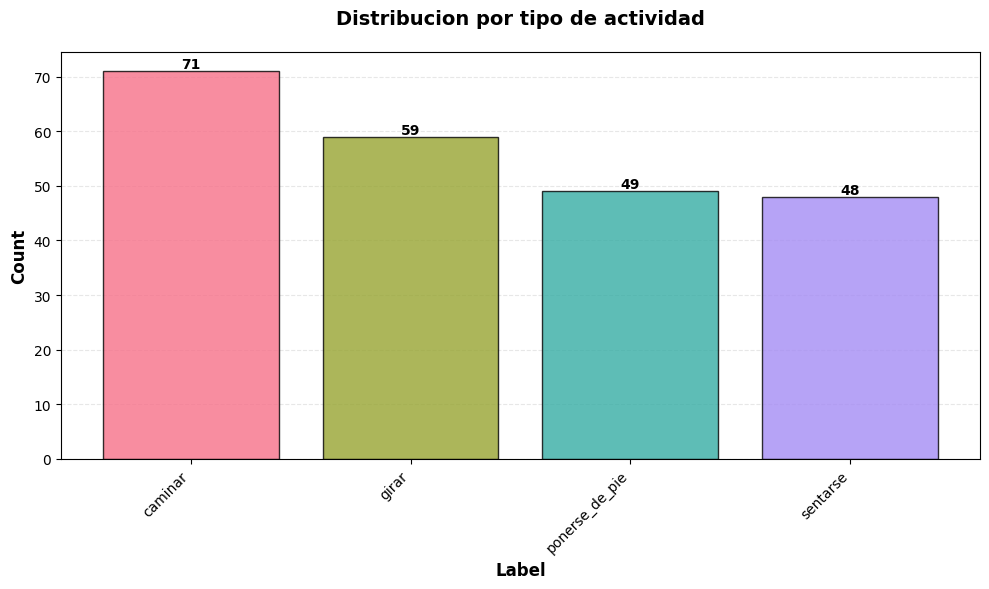

In [22]:
plot_grouped_bar_chart(df,grouping_column='label',title='Distribucion por tipo de actividad')

####Observaciones

* La base de datos se encuentra desbalanceada. Se tiene un mayor numero de muestras de personas caminando y girando que poniendose de pie y sentandose.

## Frames totales

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Distribution of total_frames'}, ylabel='Total_frames'>)

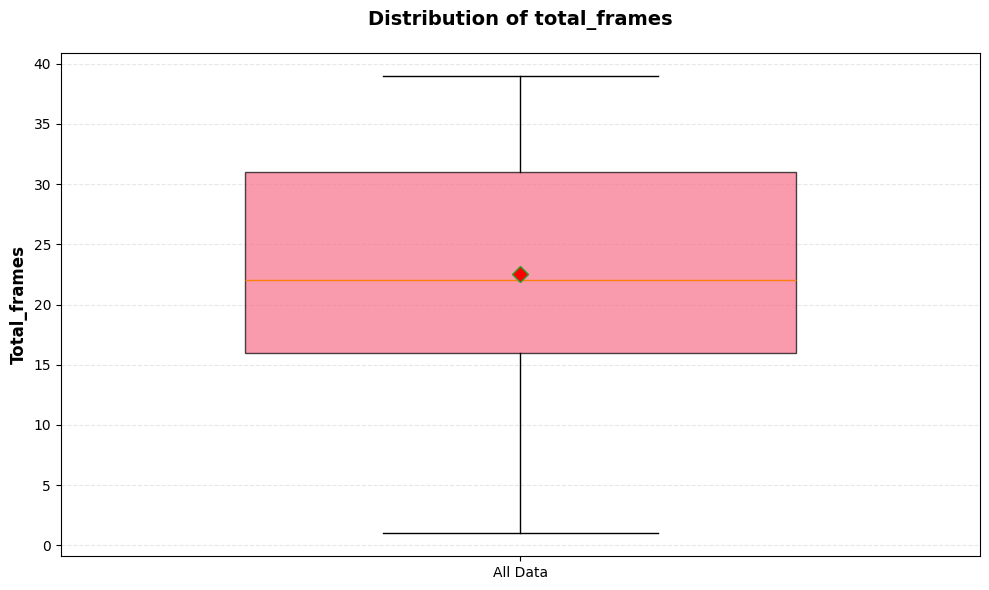

In [23]:
plot_boxplot(df,value_column='total_frames')

/tmp/ipython-input-303624461.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot,


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Distribucion de frames totales por tipo de actividad'}, xlabel='Label', ylabel='Total_frames'>)

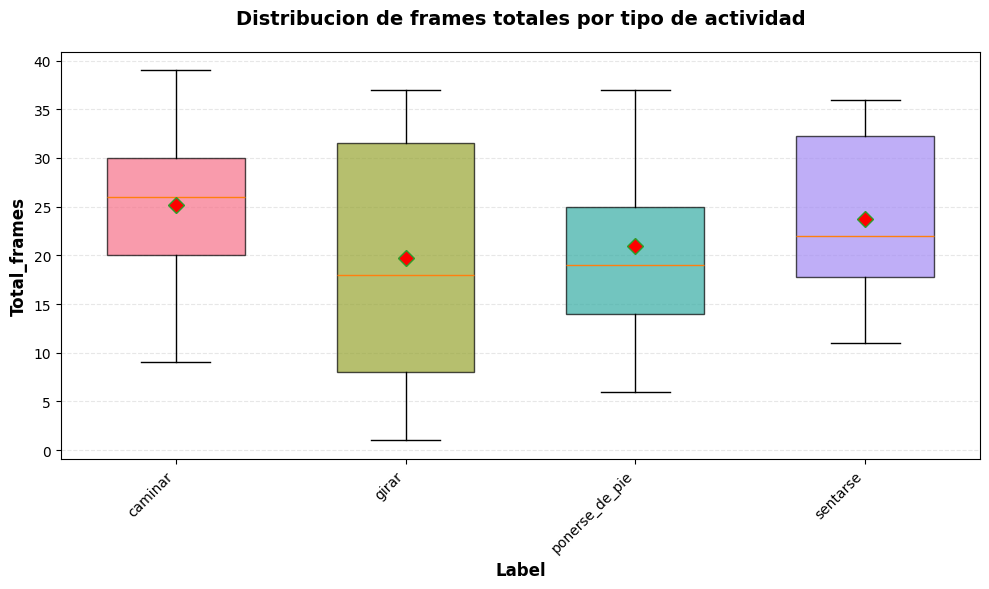

In [ ]:
plot_boxplot(df,value_column='total_frames',grouping_column='label',title="Distribucion de frames totales por tipo de actividad")

#### Observaciones

* Los videos de caminar tienen mas frames y por tanto son significativamente mas largos que las de las acciones.

* Los videos de girar tienen mucha variabilidad y tienen menos fotogramas que los demas. Esto es de esperarse porque con la accion de girar es bastante mas breve que las otras.

* Hay videos de girar con muy pocos fotogramas, es necesario gestonar eso.

Filtrados 18 videos de 'girar' con menos de 10 frames.


/tmp/ipython-input-3703230500.py:35: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=tick_labels, showmeans=True)


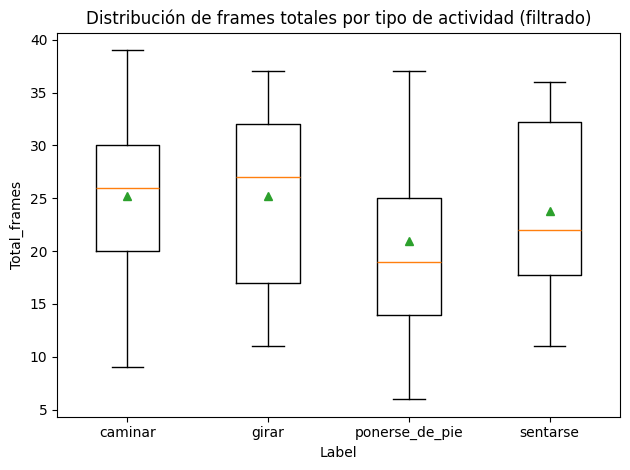

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1) Asegurar la columna total_frames desde el JSON de landmarks
if "total_frames" not in df.columns:
    def _count_frames(lm):
        if isinstance(lm, dict):
            return len(lm.get("frames", []))
        return np.nan
    df["total_frames"] = df["landmarks"].apply(_count_frames)

# 2) Calcular umbral para "girar" (outliers de baja duración)
#    Método robusto por percentil 10 + mínimo absoluto opcional
vals_girar = df.loc[df["label"] == "girar", "total_frames"].dropna().values
if vals_girar.size == 0:
    raise ValueError("No hay filas de 'girar' con total_frames para calcular umbral.")

p10 = int(np.percentile(vals_girar, 10))   # umbral por percentil 10
min_abs = 10                                 # mínimo absoluto de seguridad (ajustable)
threshold = max(p10, min_abs)

# 3) Filtrar: quitar SOLO los 'girar' por debajo del umbral
mask_low = (df["label"] == "girar") & (df["total_frames"] < threshold)
removed = int(mask_low.sum())
df_clean = df.loc[~mask_low].copy()

print(f"Filtrados {removed} videos de 'girar' con menos de {threshold} frames.")

# 4) Rehacer el boxplot con el dataset filtrado
plt.figure()
data_to_plot = [g["total_frames"].dropna().values for _, g in df_clean.groupby("label")]
tick_labels = [k for k, _ in df_clean.groupby("label")]

plt.boxplot(data_to_plot, labels=tick_labels, showmeans=True)
plt.title("Distribución de frames totales por tipo de actividad (filtrado)")
plt.xlabel("Label")
plt.ylabel("Total_frames")
plt.tight_layout()
plt.show()


Aplicando el filtro para todas las clases.

Umbrales por etiqueta (frames mínimos): {'caminar': 15, 'girar': 8, 'ponerse_de_pie': 11, 'sentarse': 14}
Eliminados por etiqueta: {'caminar': 5, 'girar': 11, 'ponerse_de_pie': 3, 'sentarse': 3}
Total eliminado: 22


/tmp/ipython-input-3259904799.py:70: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data_to_plot, labels=tick_labels, showmeans=True)


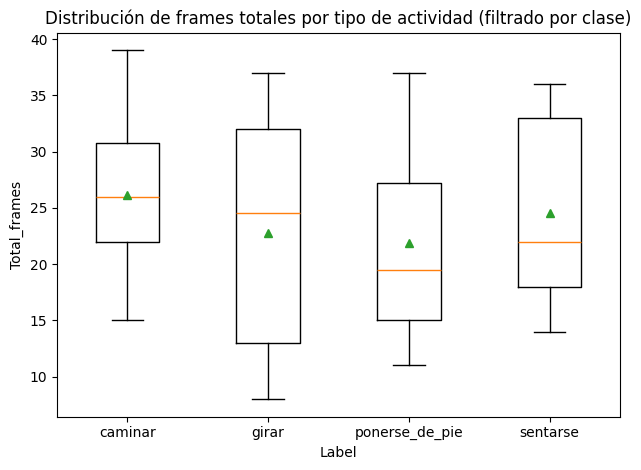

In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def ensure_total_frames(df, landmarks_col="landmarks", out_col="total_frames"):
    if out_col not in df.columns:
        def _count_frames(lm):
            if isinstance(lm, dict):
                return len(lm.get("frames", []))
            return np.nan
        df[out_col] = df[landmarks_col].apply(_count_frames)
    return df

def sanitize_short_videos(
    df,
    label_col="label",
    frames_col="total_frames",
    p=10,              # percentil por clase para definir "muy corto"
    min_abs=10,         # mínimo absoluto de seguridad
    min_per_label=None # dict opcional: {'girar': 10, 'caminar': 12, ...}
):
    df = df.copy()
    thresholds = {}
    removed_counts = {}

    for label, sub in df.groupby(label_col):
        vals = sub[frames_col].dropna().values
        if vals.size == 0:
            thresholds[label] = np.nan
            removed_counts[label] = 0
            continue

        p_thresh = int(np.percentile(vals, p))
        base = max(p_thresh, min_abs)
        if isinstance(min_per_label, dict) and label in min_per_label:
            base = max(base, int(min_per_label[label]))  # prioriza configuración por etiqueta

        thresholds[label] = base
        mask = (df[label_col] == label) & (df[frames_col] < base)
        removed_counts[label] = int(mask.sum())
        df = df.loc[~mask]

    return df, thresholds, removed_counts

# === 1) Asegurar total_frames desde landmarks
df = ensure_total_frames(df, landmarks_col="landmarks", out_col="total_frames")

# (Opcional) forzar mínimos por etiqueta si quieres políticas distintas
minimos_por_etiqueta = {
    # 'girar': 10,
    # 'caminar': 12,
    # 'ponerse_de_pie': 10,
    # 'sentarse': 10,
}

# === 2) Saneamiento para TODAS las clases
df_clean, umbrales, removidos = sanitize_short_videos(
    df, label_col="label", frames_col="total_frames",
    p=10, min_abs=8, min_per_label=minimos_por_etiqueta
)

print("Umbrales por etiqueta (frames mínimos):", umbrales)
print("Eliminados por etiqueta:", removidos)
print(f"Total eliminado: {sum(removidos.values())}")

# === 3) Rehacer el boxplot con el dataset filtrado
plt.figure()
data_to_plot = [g["total_frames"].dropna().values for _, g in df_clean.groupby("label")]
tick_labels  = [k for k, _ in df_clean.groupby("label")]
plt.boxplot(data_to_plot, labels=tick_labels, showmeans=True)
plt.title("Distribución de frames totales por tipo de actividad (filtrado por clase)")
plt.xlabel("Label")
plt.ylabel("Total_frames")
plt.tight_layout()
plt.show()


## Nivel de iluminacion

(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Distribucion de nivel de iluminacion'}, ylabel='Lighting'>)

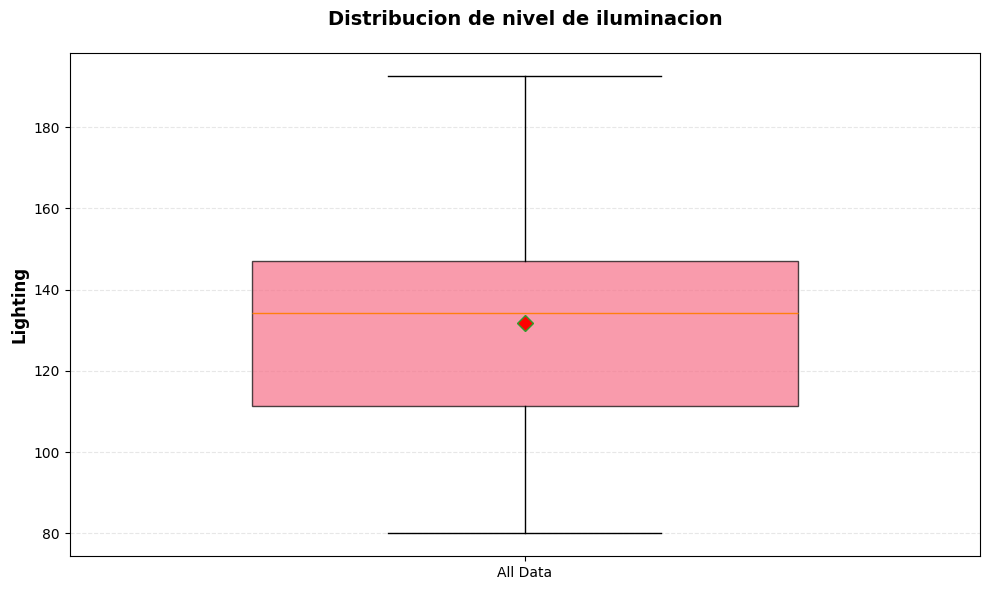

In [ ]:
plot_boxplot(df,value_column='lighting',title="Distribucion de nivel de iluminacion")

/tmp/ipython-input-303624461.py:55: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax.boxplot(data_to_plot,


(<Figure size 1000x600 with 1 Axes>,
 <Axes: title={'center': 'Distribucion de nivel de iluminacion'}, xlabel='Label', ylabel='Lighting'>)

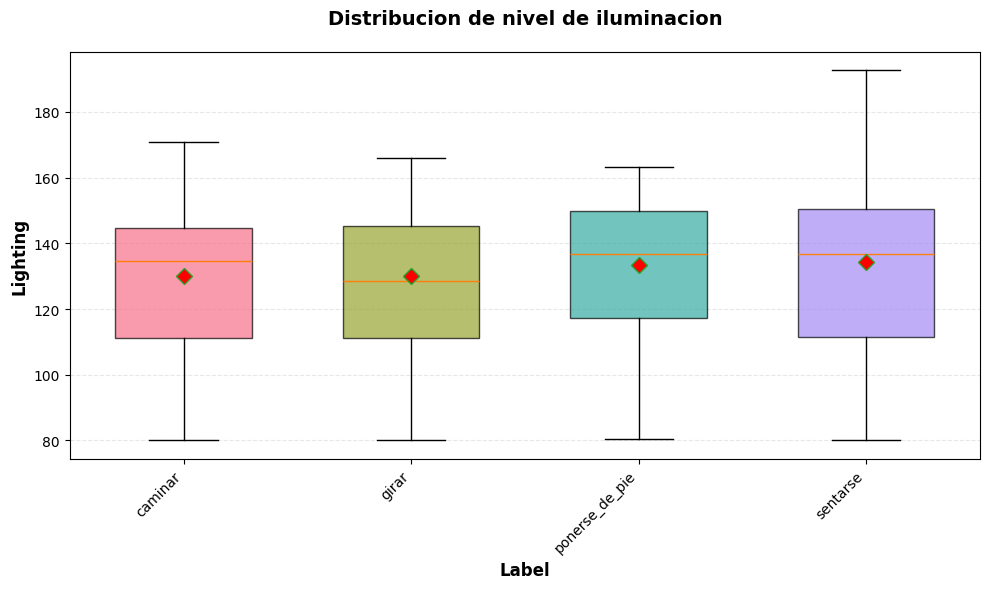

In [ ]:
plot_boxplot(df,value_column='lighting',title="Distribucion de nivel de iluminacion",grouping_column='label')

#### Observaciones

* Todos los videos presentan niveles de iluminacion semejantes. No hay disparidades en este apartado.

## Nivel de visibilidad

In [ ]:
def add_visibility_per_region(df, regions):
  df=df = df.copy()
  for region_name,fields in regions.items():
    df[f"{region_name}_visibility_mean"] = df["landmarks"].apply(lambda x: np.mean([frame["landmarks"][field]["visibility"] for frame in x["frames"] for field in fields]))
    df[f"{region_name}_visibility_std"] = df["landmarks"].apply(lambda x: np.std([frame["landmarks"][field]["visibility"] for frame in x["frames"] for field in fields]))
    df[f"{region_name}_visibility_min"] = df["landmarks"].apply(lambda x: np.min([frame["landmarks"][field]["visibility"] for frame in x["frames"] for field in fields]))
  return df

In [ ]:
df_with_visibilitymetrics=add_visibility_per_region(df,REGIONS)

In [ ]:
df_with_visibilitymetrics.head()

,fps,resolution,width,height,duration_sec,lighting,label,video_id,landmarks,total_frames,...,hombros_visibility_min,brazos_visibility_mean,brazos_visibility_std,brazos_visibility_min,caderas_visibility_mean,caderas_visibility_std,caderas_visibility_min,piernas_visibility_mean,piernas_visibility_std,piernas_visibility_min
0,30.000000,3840x2160,3840,2160,4.500000,157.094944,caminar,8e26196e-4e06-40fe-9ca2-809f0858685c,"{'fps': 30.0, 'frames': [{'landmarks': {'head'...",27,...,0.999913,0.980187,0.008506,0.956293,0.999750,0.000217,0.999063,0.954105,0.081010,0.587607
1,30.000000,3840x2160,3840,2160,5.233333,154.564334,caminar,1d00f9dc-1af5-49d0-9210-f56186842ec9,"{'fps': 30.0, 'frames': [{'landmarks': {'head'...",32,...,0.997780,0.527178,0.422563,0.064077,0.998202,0.001710,0.991841,0.757469,0.259110,0.086577
2,30.009681,3840x2160,3840,2160,5.165000,160.723702,caminar,5276d09c-8ec6-4aec-83b4-078748e0e64a,"{'fps': 30.00968054211036, 'frames': [{'landma...",31,...,0.995477,0.788517,0.267935,0.121831,0.998902,0.001126,0.995074,0.932471,0.079948,0.674094
3,30.000000,3840x2160,3840,2160,5.533333,133.000277,caminar,e5a147db-56e5-4f93-93c0-dd751c2021d1,"{'fps': 30.0, 'frames': [{'landmarks': {'head'...",26,...,0.965882,0.407431,0.232093,0.171565,0.984079,0.005779,0.966133,0.510093,0.150192,0.185303
4,30.000000,3840x2160,3840,2160,4.633333,138.399014,caminar,d37fe29e-8b8e-4080-9071-a5fa5a5bb71e,"{'fps': 30.0, 'frames': [{'landmarks': {'head'...",23,...,0.995333,0.970582,0.044417,0.758656,0.999145,0.002036,0.990354,0.926893,0.144538,0.309276


In [ ]:
import warnings

def plot_boxplots_by_suffix(df, suffix, grouping_column='label', ylabel=None):
    """
    Creates boxplots for all columns ending with a specific suffix

    Args:
        df: DataFrame
        suffix: str - suffix to filter columns (e.g., 'visibility_mean', 'visibility_std')
        grouping_column: str - column to group by
        ylabel: str - y-axis label (optional, auto-generated if None)
    """
    # Get columns that end with suffix
    cols = [col for col in df.columns if col.endswith(suffix)]

    # Suppress deprecation warnings
    warnings.filterwarnings("ignore", category=DeprecationWarning)

    # Default ylabel
    if ylabel is None:
        ylabel = suffix.replace('_', ' ').title()

    # Create boxplots
    for col in cols:
        region_name = col.replace(f'_{suffix}', '').capitalize()
        title = f"Distribution of {suffix.replace('_', ' ').title()} - {region_name}"

        plot_boxplot(df,
                    value_column=col,
                    grouping_column=grouping_column,
                    title=title,
                    ylabel=ylabel)
        plt.show()


In [ ]:
def plot_all_visibility_mean_boxplots(df,  grouping_column='label', ylabel=None):
  return plot_boxplots_by_suffix(df, suffix='visibility_mean', grouping_column='label')
def plot_all_visibility_std_boxplots(df,  grouping_column='label', ylabel=None):
  return plot_boxplots_by_suffix(df, suffix='visibility_std', grouping_column='label')


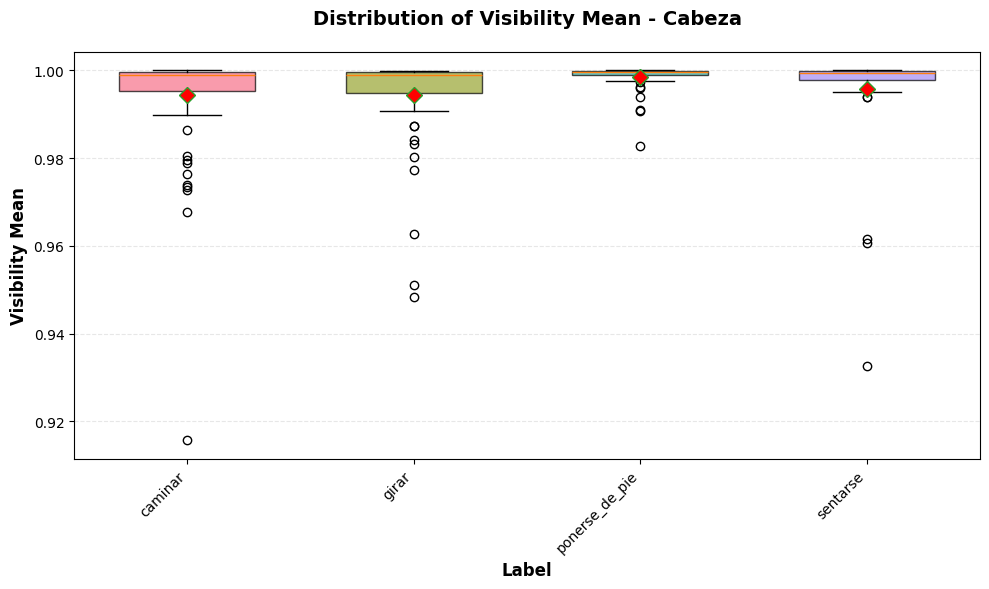

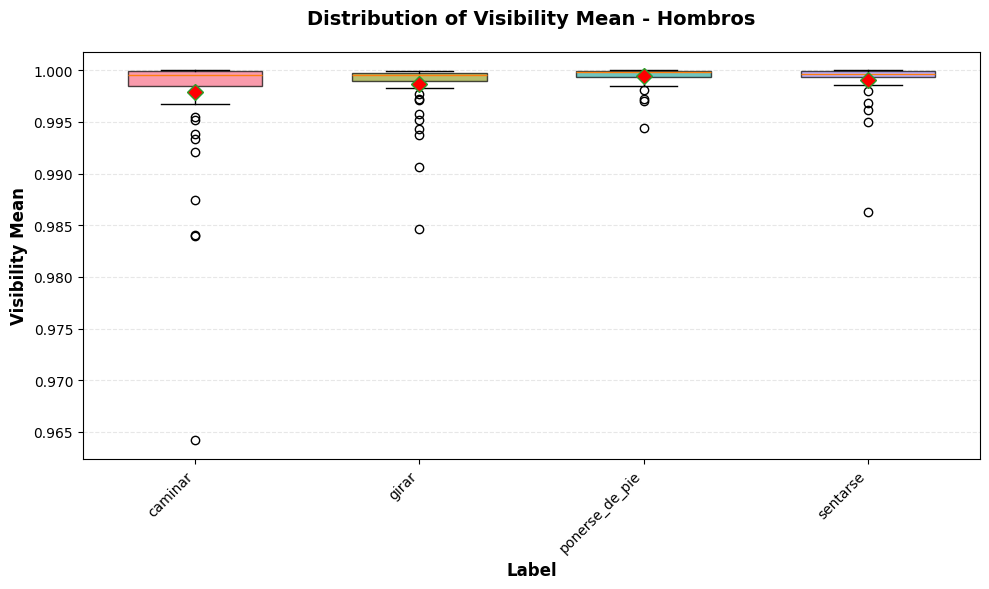

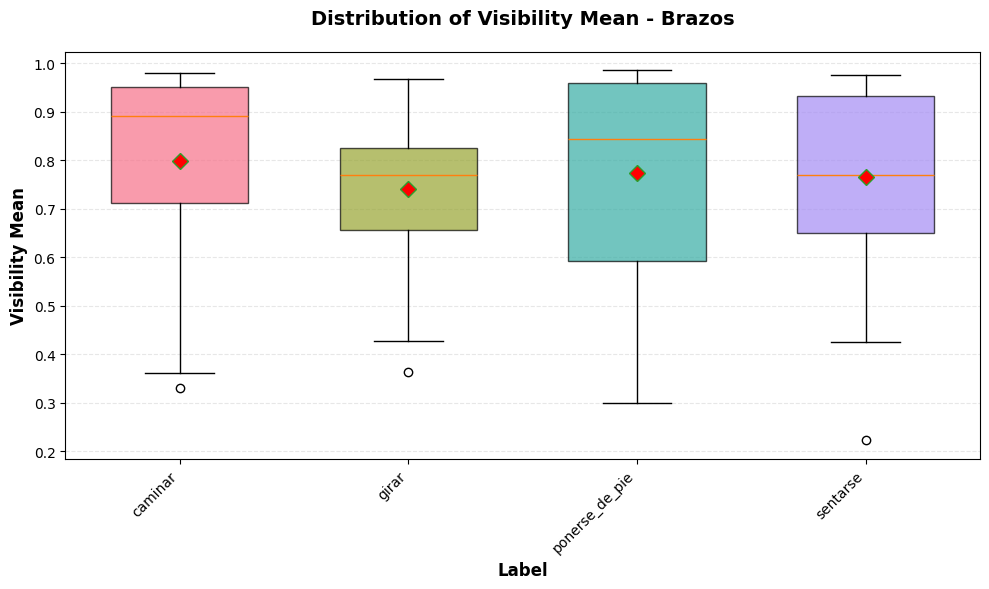

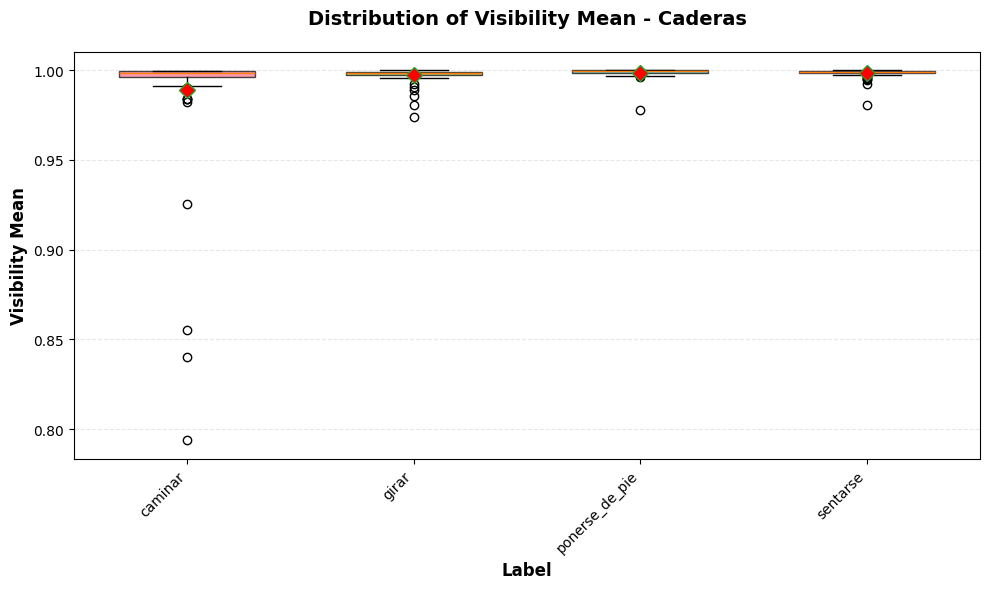

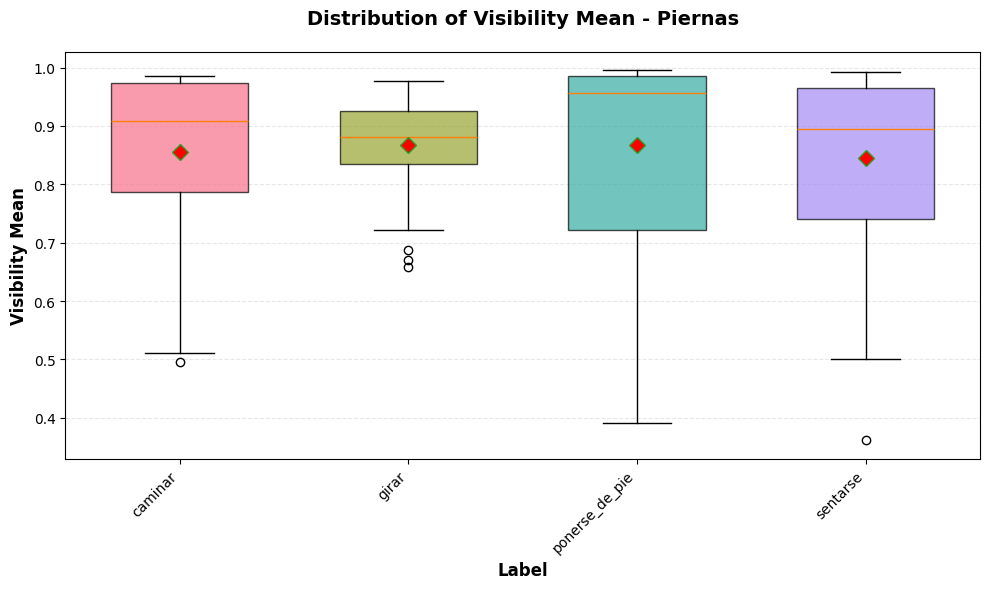

In [ ]:
plot_all_visibility_mean_boxplots(df_with_visibilitymetrics, grouping_column='label')

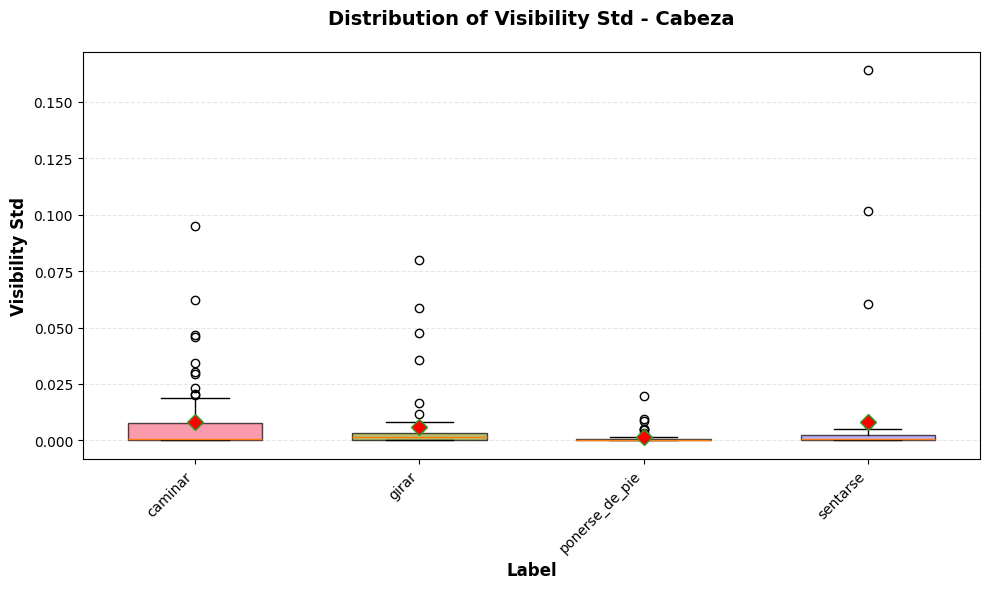

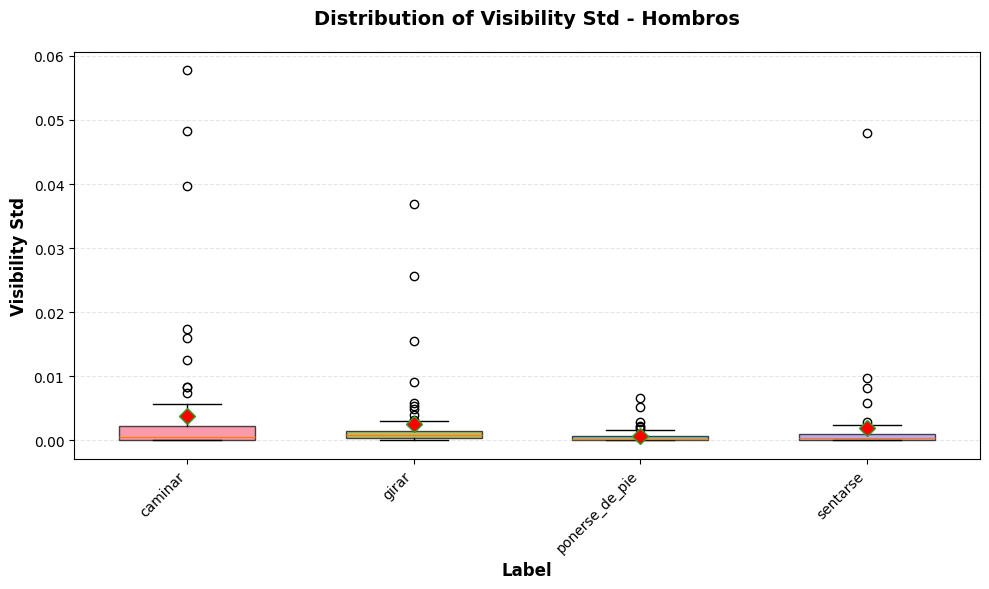

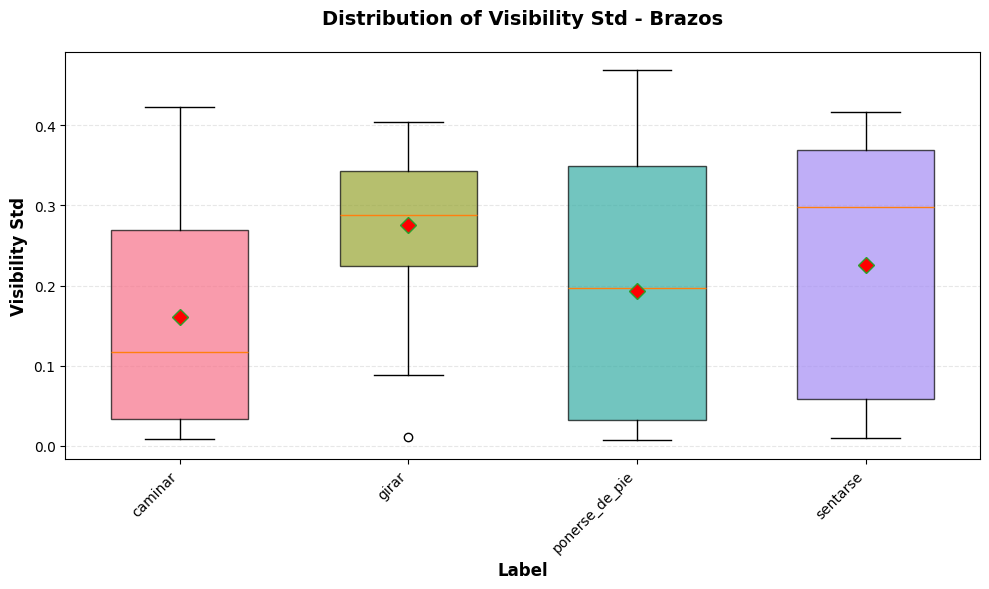

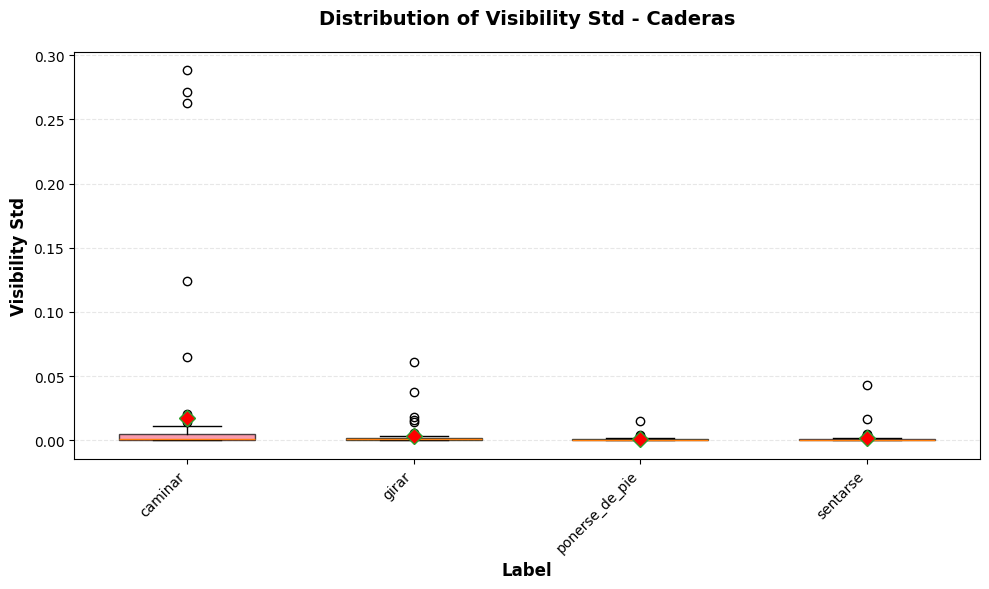

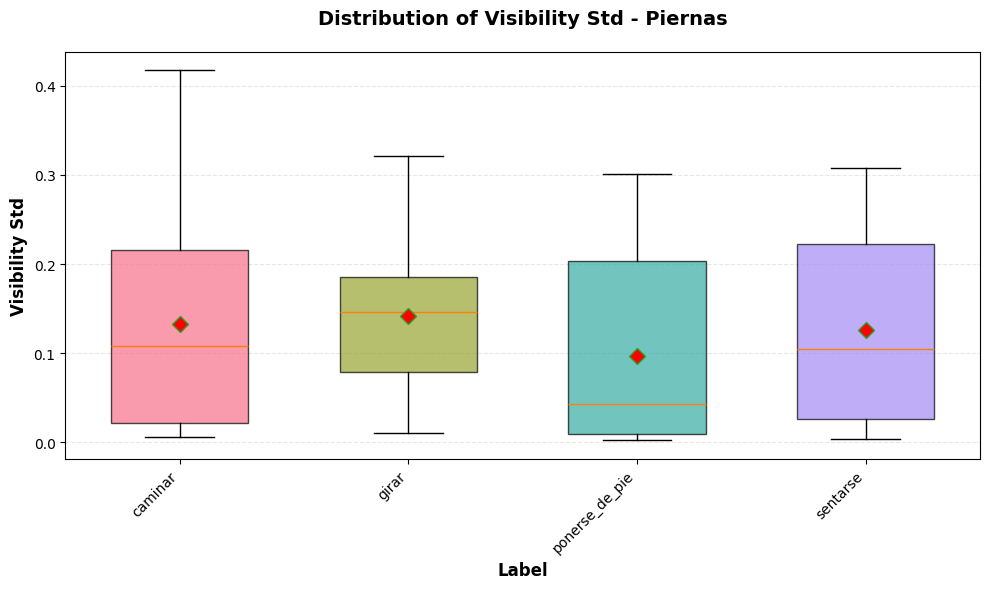

In [ ]:
plot_all_visibility_std_boxplots(df_with_visibilitymetrics, grouping_column='label')

#### Observaciones

* NO se alcanza a discernir ningun patron especifico. Las accion de caminar suele tener un mayor una mayor visibilidad en todas las regiones, pero esto puede ser porque su numero de muestras es mayor.

* La distribucion de la visibilidad de las regiones tambien es muy similar entre los videos.



## Desplazamiento

In [ ]:
def add_displacement_per_region(df, regions):
    """
    Calcula el movimiento total acumulado por región.
    Suma de distancias euclidianas entre frames consecutivos.
    También identifica la región con mayor y menor movimiento.
    """
    df = df.copy()

    # Calcular movimiento por región
    for region_name, fields in regions.items():
        def calculate_movement(x):
            frames = x["frames"]
            if len(frames) < 2:
                return 0.0

            total_movement = 0.0

            for i in range(len(frames) - 1):
                # Posición promedio de la región en frame actual
                pos_curr = np.array([
                    np.mean([frames[i]["landmarks"][f]["x"] for f in fields]),
                    np.mean([frames[i]["landmarks"][f]["y"] for f in fields]),
                    np.mean([frames[i]["landmarks"][f]["z"] for f in fields])
                ])

                # Posición promedio de la región en frame siguiente
                pos_next = np.array([
                    np.mean([frames[i+1]["landmarks"][f]["x"] for f in fields]),
                    np.mean([frames[i+1]["landmarks"][f]["y"] for f in fields]),
                    np.mean([frames[i+1]["landmarks"][f]["z"] for f in fields])
                ])

                # Distancia euclidiana
                distance = np.linalg.norm(pos_next - pos_curr)
                total_movement += distance

            return total_movement

        df[f"{region_name}_movement_total"] = df["landmarks"].apply(calculate_movement)

    # Identificar región con mayor y menor movimiento
    movement_columns = [f"{region_name}_movement_total" for region_name in regions.keys()]

    df["region_with_max_movement"] = df[movement_columns].idxmax(axis=1).str.replace("_movement_total", "")
    df["region_with_min_movement"] = df[movement_columns].idxmin(axis=1).str.replace("_movement_total", "")

    return df






In [ ]:
df_with_movement = add_displacement_per_region(df, REGIONS)

In [ ]:
def plot_all_movement_total_boxplots(df,  grouping_column='label', ylabel=None):
  return plot_boxplots_by_suffix(df, suffix='movement_total', grouping_column='label')

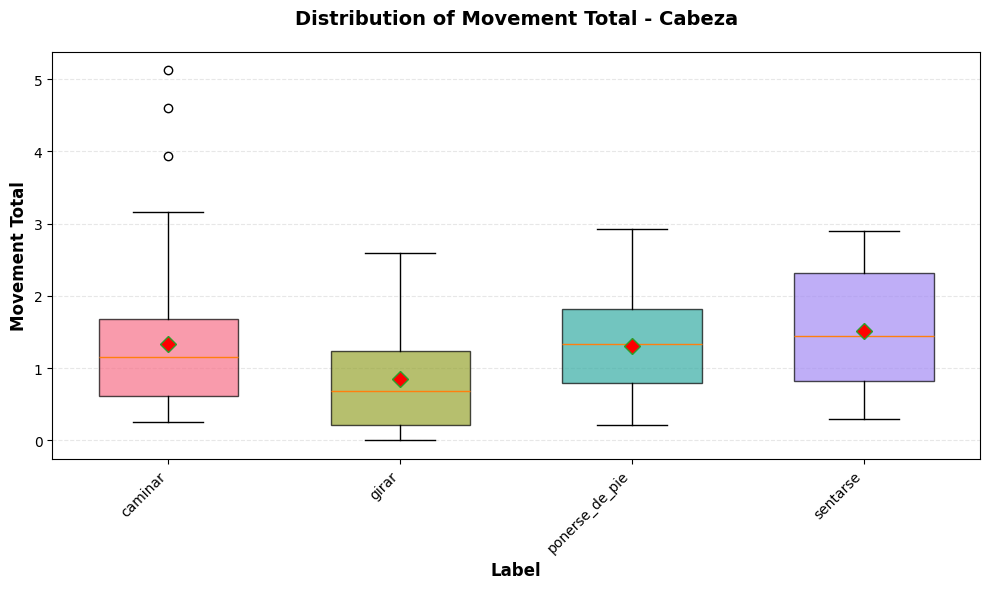

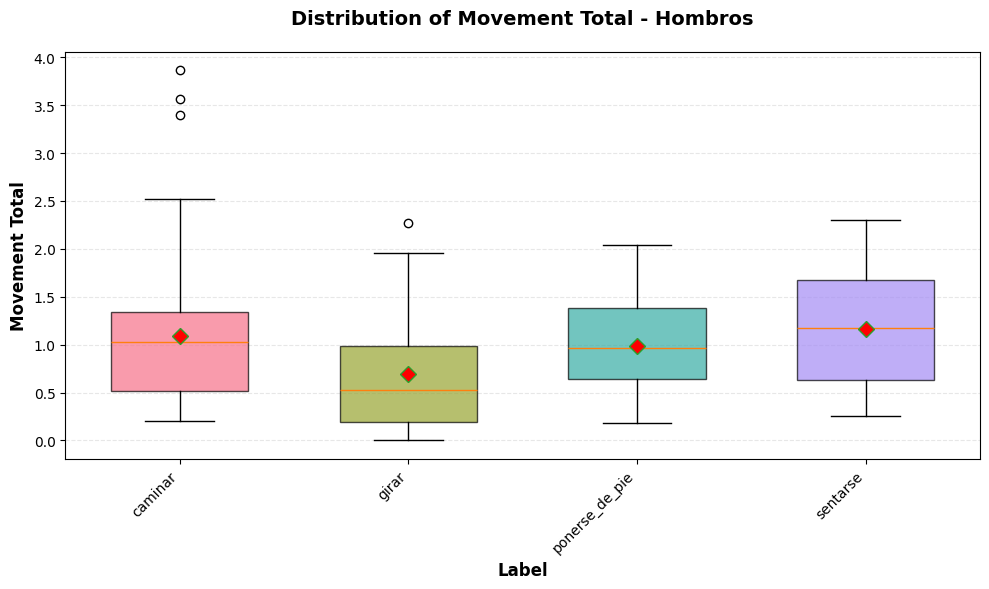

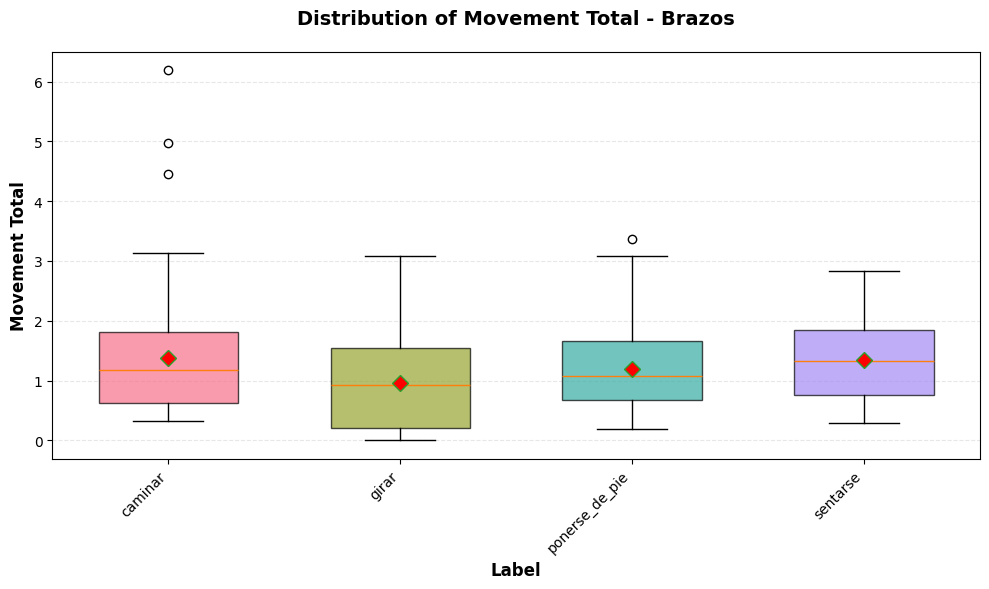

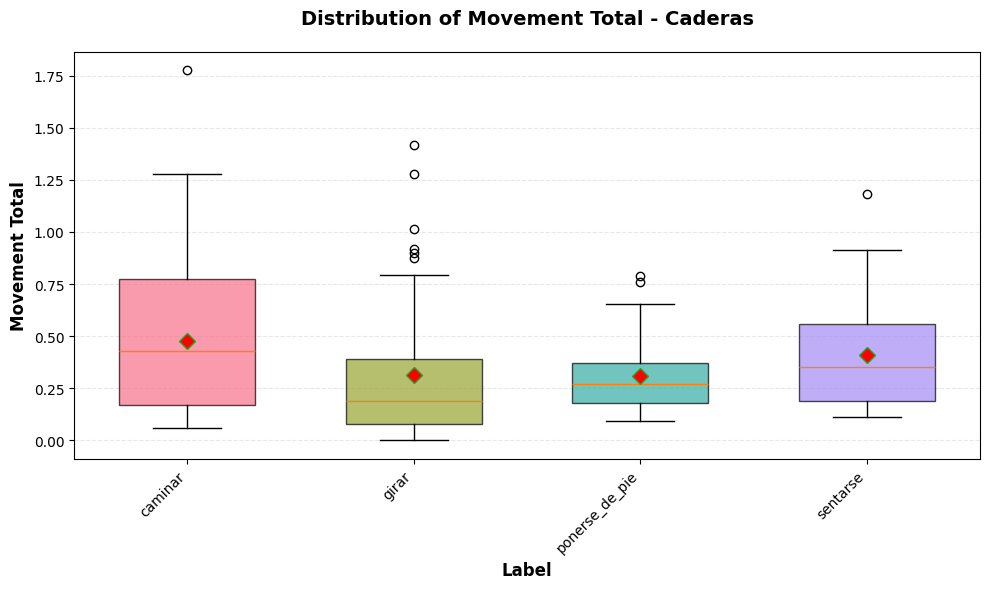

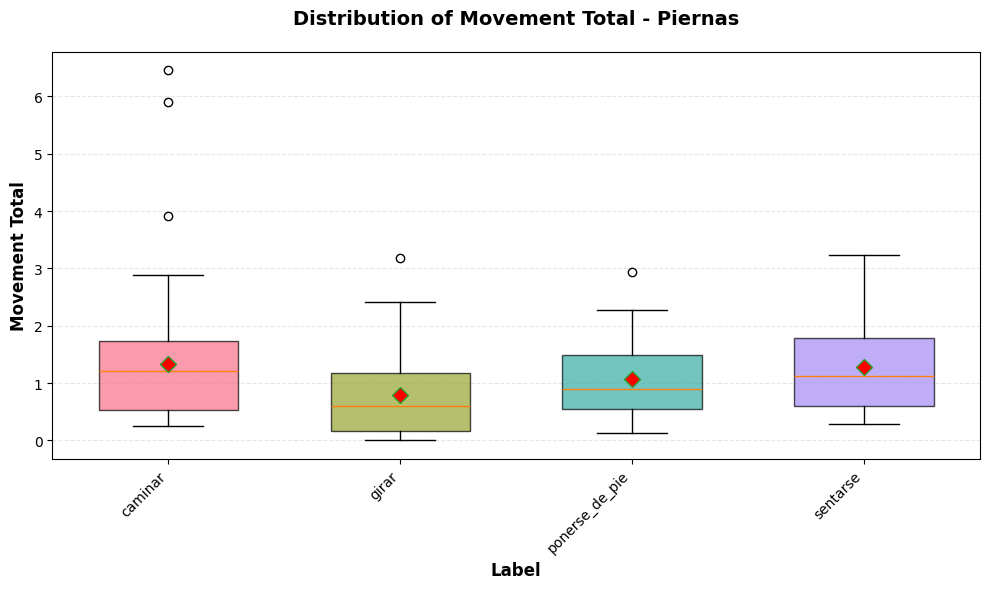

In [ ]:
plot_all_movement_total_boxplots(df_with_movement, grouping_column='label')

In [ ]:
def get_movement_mode_by_label(df):
    """
    Genera una tabla mostrando la región más frecuente con mayor y menor movimiento
    para cada actividad.

    Args:
        df: DataFrame con columnas 'label', 'region_with_max_movement', 'region_with_min_movement'

    Returns:
        DataFrame con regiones más frecuentes por actividad
    """
    results = []

    for label in sorted(df['label'].unique()):
        subset = df[df['label'] == label]

        if subset.empty:
            continue

        # MAYOR MOVIMIENTO
        max_movement = subset['region_with_max_movement']
        max_mode = max_movement.mode()[0] if not max_movement.mode().empty else 'N/A'
        max_count = (max_movement == max_mode).sum()
        max_total = len(max_movement)
        max_pct = (max_count / max_total * 100) if max_total > 0 else 0

        # MENOR MOVIMIENTO
        min_movement = subset['region_with_min_movement']
        min_mode = min_movement.mode()[0] if not min_movement.mode().empty else 'N/A'
        min_count = (min_movement == min_mode).sum()
        min_total = len(min_movement)
        min_pct = (min_count / min_total * 100) if min_total > 0 else 0

        results.append({
            'Actividad': label,
            'Total Videos': max_total,
            'Región con Mayor Movimiento': f"{max_mode} ({max_pct:.1f}%)",
            'Región con Menor Movimiento': f"{min_mode} ({min_pct:.1f}%)"
        })

    result_df = pd.DataFrame(results)

    return result_df







In [ ]:
get_movement_mode_by_label(df_with_movement)

,Actividad,Total Videos,Región con Mayor Movimiento,Región con Menor Movimiento
0,caminar,71,cabeza (33.8%),caderas (100.0%)
1,girar,59,brazos (49.2%),caderas (98.3%)
2,ponerse_de_pie,49,cabeza (55.1%),caderas (98.0%)
3,sentarse,48,cabeza (62.5%),caderas (100.0%)


#### Observaciones

* Como es de esperarse, en los videos en donde las personas se paran o ponen de pie, la region con mayor movimiento es la cabeza, a pesar de que los histogramas indican que, en lineas generales, la cabeza se mueve mas en caminar que en ponerse de pie. Para momentos posteriores puede llegar a ser beneficioso analizar tambien la direccion en la que se presento el mayor movimiento.

* Caminar practicamente tiene mayor movimiento en cada una de las regiones con respecto a los otros tipos de acciones.

* Para todos los casos la region con menor movimiento es la cadera.

* El movimiento de la cabeza en los videos en donde las personas se sientan y se paran es muy similar.






## Velocidad Euclidiana Promedio

In [ ]:
def add_speed_per_region(df, regions):
    """
    Calcula la rapidez promedio (velocidad euclidiana) por región.
    Usa el timestamp de cada frame para calcular el tiempo real transcurrido.
    También identifica la región con mayor y menor velocidad.

    Args:
        df: DataFrame con columna 'landmarks' que contiene frames con timestamp
        regions: dict con regiones y sus landmarks

    Returns:
        DataFrame con columnas <region>_speed_mean y region_with_max/min_velocity
    """
    df = df.copy()

    # Calcular velocidad por región
    for region_name, fields in regions.items():
        def calculate_speed(x):
            frames = x["frames"]
            if len(frames) < 2:
                return 0.0

            speeds = []

            for i in range(len(frames) - 1):
                # Posición promedio de la región en frame actual
                pos_curr = np.array([
                    np.mean([frames[i]["landmarks"][f]["x"] for f in fields]),
                    np.mean([frames[i]["landmarks"][f]["y"] for f in fields]),
                    np.mean([frames[i]["landmarks"][f]["z"] for f in fields])
                ])

                # Posición promedio de la región en frame siguiente
                pos_next = np.array([
                    np.mean([frames[i+1]["landmarks"][f]["x"] for f in fields]),
                    np.mean([frames[i+1]["landmarks"][f]["y"] for f in fields]),
                    np.mean([frames[i+1]["landmarks"][f]["z"] for f in fields])
                ])

                # Distancia euclidiana
                distance = np.linalg.norm(pos_next - pos_curr)

                # Tiempo transcurrido entre frames (en segundos)
                time_diff = frames[i+1]["timestamp"] - frames[i]["timestamp"]

                # Evitar división por cero
                if time_diff > 0:
                    speed = distance / time_diff  # distancia por segundo
                    speeds.append(speed)

            # Promedio de velocidades (rapidez promedio)
            return np.mean(speeds) if speeds else 0.0

        df[f"{region_name}_speed_mean"] = df["landmarks"].apply(calculate_speed)

    # Identificar región con mayor y menor velocidad
    speed_columns = [f"{region_name}_speed_mean" for region_name in regions.keys()]

    df["region_with_max_velocity"] = df[speed_columns].idxmax(axis=1).str.replace("_speed_mean", "")
    df["region_with_min_velocity"] = df[speed_columns].idxmin(axis=1).str.replace("_speed_mean", "")

    return df


In [ ]:
df_with_speed=add_speed_per_region(df,REGIONS)

In [ ]:
def plot_all_speed_mean_boxplots(df,  grouping_column='label', ylabel=None):
  return plot_boxplots_by_suffix(df, suffix='_speed_mean', grouping_column='label')

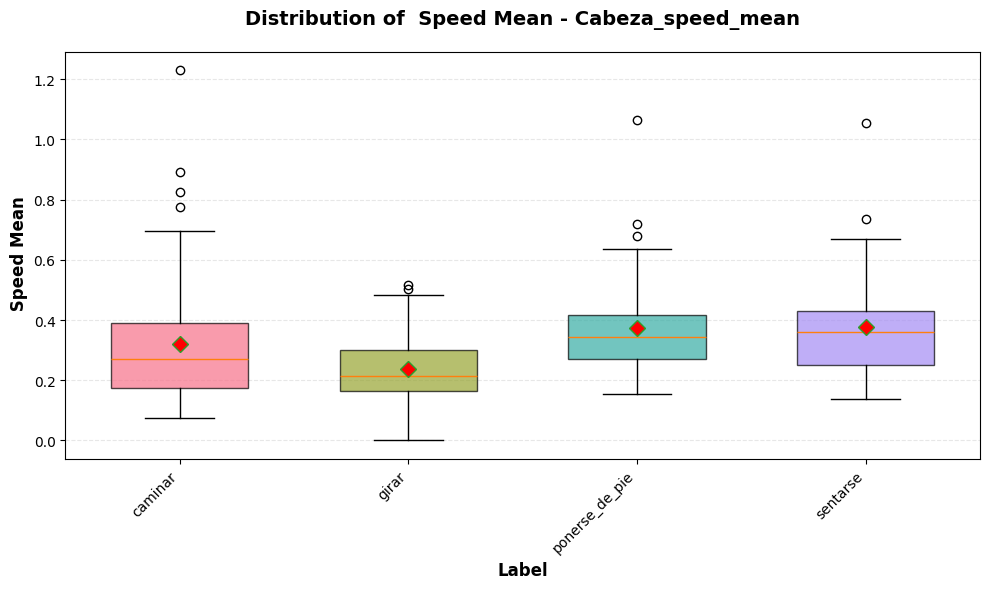

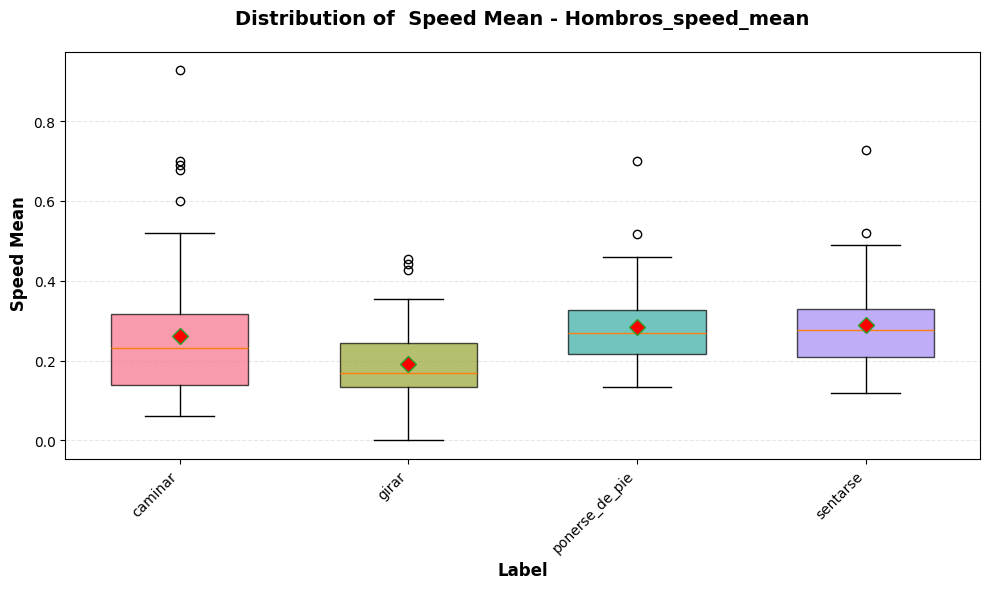

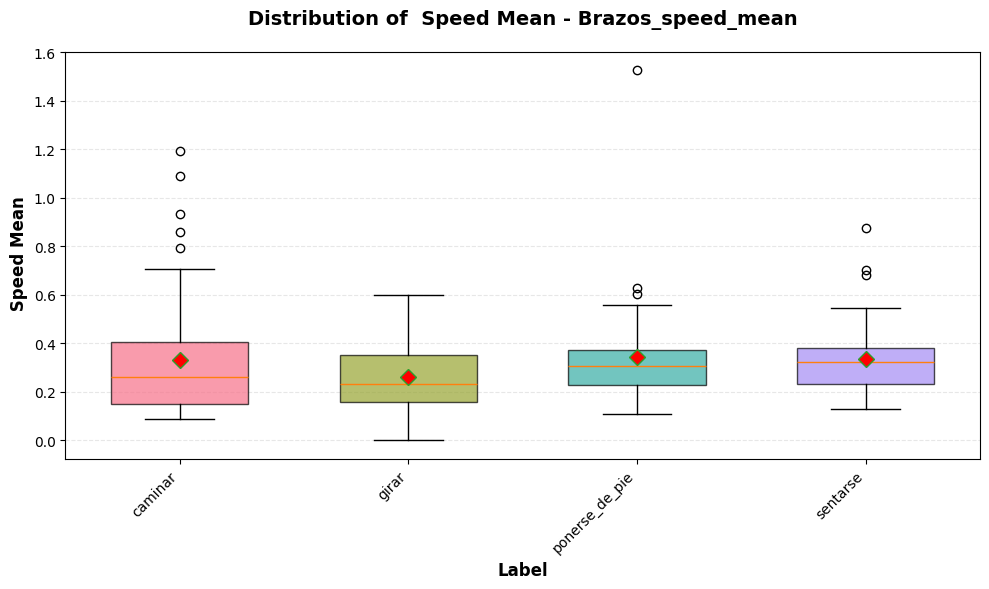

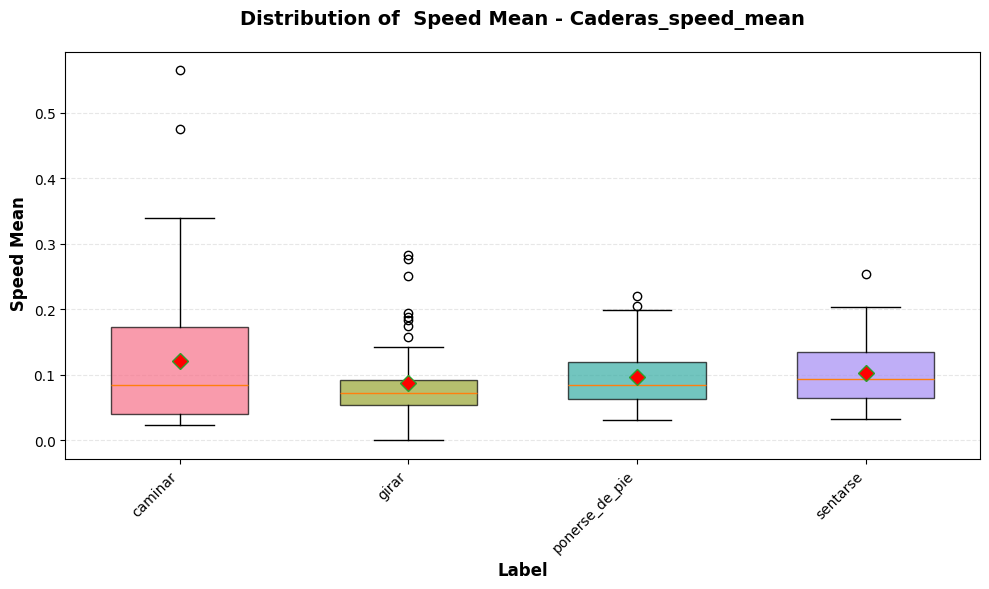

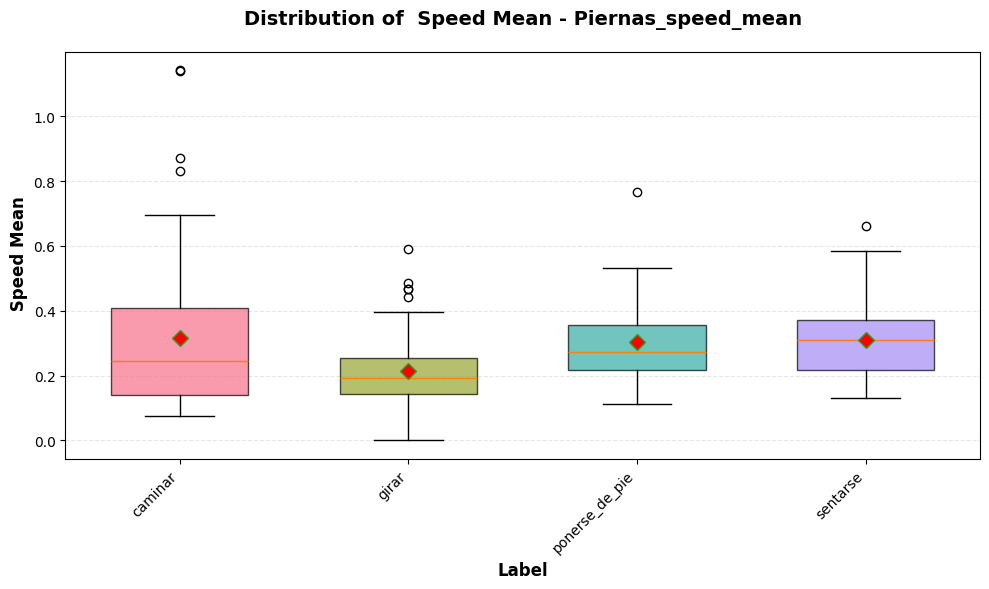

In [ ]:
plot_all_speed_mean_boxplots(df_with_speed, grouping_column='label')

In [ ]:
def get_velocity_mode_by_label(df):
    """
    Genera una tabla mostrando la región más frecuente con mayor y menor velocidad
    para cada actividad.

    Args:
        df: DataFrame con columnas 'label', 'region_with_max_velocity', 'region_with_min_velocity'

    Returns:
        DataFrame con regiones más frecuentes por actividad
    """
    results = []

    for label in sorted(df['label'].unique()):
        subset = df[df['label'] == label]

        if subset.empty:
            continue

        # MAYOR VELOCIDAD
        max_velocity = subset['region_with_max_velocity']
        max_mode = max_velocity.mode()[0] if not max_velocity.mode().empty else 'N/A'
        max_count = (max_velocity == max_mode).sum()
        max_total = len(max_velocity)
        max_pct = (max_count / max_total * 100) if max_total > 0 else 0

        # MENOR VELOCIDAD
        min_velocity = subset['region_with_min_velocity']
        min_mode = min_velocity.mode()[0] if not min_velocity.mode().empty else 'N/A'
        min_count = (min_velocity == min_mode).sum()
        min_total = len(min_velocity)
        min_pct = (min_count / min_total * 100) if min_total > 0 else 0

        results.append({
            'Actividad': label,
            'Total Videos': max_total,
            'Región con Mayor Velocidad': f"{max_mode} ({max_pct:.1f}%)",
            'Región con Menor Velocidad': f"{min_mode} ({min_pct:.1f}%)"
        })

    result_df = pd.DataFrame(results)

    return result_df

In [ ]:
# Generar tabla
velocity_mode_table = get_velocity_mode_by_label(df_with_speed)

print(velocity_mode_table.to_string(index=False))

     Actividad  Total Videos Región con Mayor Velocidad Región con Menor Velocidad
       caminar            71             cabeza (33.8%)           caderas (100.0%)
         girar            59             brazos (49.2%)            caderas (98.3%)
ponerse_de_pie            49             cabeza (55.1%)            caderas (98.0%)
      sentarse            48             cabeza (62.5%)           caderas (100.0%)


#### Observaciones

* La cabeza se mueve con mayor velocidad en acciones donde las personas se sientan y se ponen de pie.

* La region con mayor velocidad al caminar fue cabeza. Aunque por muy poco, esto es positivo, porque el sentido comun indica que todas las regiones deben moverse con velocidad similar al caminar.

* La region con menor velocidad, al igual que con lo que paso con la de movimiento, fueron las caderas.